# Build a Book Recommender System

Recommender systems are used in all sorts of organizations to help users make decisions and, for many companies, earn more revenue. Prototyping simple recommender systems also does not need to take a lot of time. In this project, we will build a book recommender system for Books’R’Us using Surprise.

Books’R’Us is a national bookstore chain that sells books of all sorts to people all over the country. They recently have built their website, and now want to add a book recommender system to their site. We will prepare and train the recommender system using book review data left on their site. This data has been put together in a Pandas DataFrame called book_ratings.

## Prepare your data for recommender implementation

1. Take a sneak peek into the dataset by printing the first five rows. How big is the dataset? What are the data types of the different fields?

In [1]:
import pandas as pd
from surprise import Reader

book_ratings = pd.read_csv('goodreads_ratings.csv')
print(book_ratings.head())

print('Dataset size: ', book_ratings.shape)
print('Dataset columns: ', book_ratings.columns)

                            user_id   book_id  \
0  d089c9b670c0b0b339353aebbace46a1   7686667   
1  6dcb2c16e12a41ae0c6c38e9d46f3292  18073066   
2  244e0ce681148a7586d7746676093ce9  13610986   
3  73fcc25ff29f8b73b3a7578aec846394  27274343   
4  f8880e158a163388a990b64fec7df300  11614718   

                          review_id  rating  \
0  3337e0e75701f7f682de11638ccdc60c       3   
1  7201aa3c1161f2bad81258b6d4686c16       5   
2  07a203f87bfe1b65ff58774667f6f80d       5   
3  8be2d87b07098c16f9742020ec459383       1   
4  a29c4ba03e33ad073a414ac775266c5f       4   

                                         review_text  \
0  Like Matched, this book felt like it was echoi...   
1  WOW again! 4,5 Stars \r\n So i wont forget to ...   
2  The second novel was hot & heavy. Not only in ...   
3  What a maddening waste of time. And I unfortun...   
4  4.5 stars! \r\n This was an awesome read! \r\n...   

                       date_added                    date_updated  \
0  Fri Apr 29 14

2. In order to understand these ratings, let’s look at a count of all the ratings in the data. Examine the distribution of the ratings using value_counts.

In [2]:
print('Ratings distribution:')
print(book_ratings.rating.value_counts())

Ratings distribution:
rating
4    1278
5    1001
3     707
2     269
1     125
0     120
Name: count, dtype: int64


3. Unfortunately, it appears we have some data where the ratings are 0. The ratings on the website only go from 1 to 5 inclusive. Filter out all ratings that are not in this range.

In [3]:
book_ratings = book_ratings[book_ratings['rating'] != 0]

3.5. Is the data normal distributed? Assure that the data is normal distributed to define a method to improve the accuracy

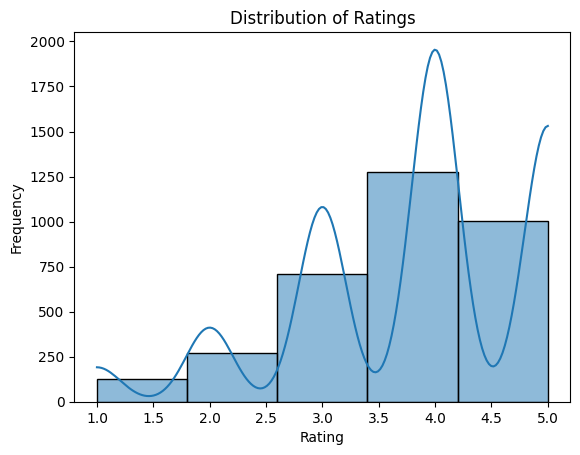

Shapiro-Wilk Test p-value: 8.314727285162022e-48


In [4]:
## Visual way

import matplotlib.pyplot as plt
import seaborn as sns

### Example ratings distribution
ratings = [4]*1278 + [5]*1001 + [3]*707 + [2]*269 + [1]*125

### Histogram with KDE (Kernel Density Estimate)
sns.histplot(ratings, bins=5, kde=True)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")
plt.show()

## Statistical way

from scipy.stats import shapiro

stat, p = shapiro(ratings)
print(f"Shapiro-Wilk Test p-value: {p}") # < 5 is not normal distributed, >= is normal distributed

# Because our p value is below 0.5, we can not use the Z-Score method to normalize the data (as in the begginning we tried to use)
# So we will use the min max method to normalize the ratings at the end of the 9th point

4. We need to prepare this data for use in Surprise. First, build a Surprise reader Object that utilizes the rating scale established above. Look at the Surprise documentation to help you out.

In [5]:
from surprise import Reader

reader = Reader(rating_scale=(1, 5)) # Define the scale

## Build a recommender system using `Surprise`

5. Load book_ratings into a Surprise Dataset so it can be used with Surprise‘s algorithms.

In [6]:
from surprise import Dataset

books = Dataset.load_from_df(book_ratings[['user_id',
                                              'book_id',
                                              'rating']],
                                reader)

6. We have a dataset that is ready for use in Surprise. Split the data, and put 80% of the data into a training set, and 20% into a test set. Set a random_state of 7 to improve reproducibility.

In [7]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(books, test_size=0.2, random_state = 7)

7. We can finally train a recommender system. Use the KNNBasic from Surprise to train a collaborative filter using the training set.

In [8]:
from surprise import KNNBasic

book_recommender = KNNBasic()
book_recommender.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


8. How good is the algorithm we trained? Calculate the RMSE of the recommender system using the testset data.

In [9]:
from surprise import accuracy

predictions = book_recommender.test(testset)
accuracy.rmse(predictions) # 1.1105, the result is bad, so we can normalize the data to improve the result

RMSE: 1.1105


1.110471008157185

9. Time to get a recommendation! User 8842281e1d1347389f2ab93d60773d4d gave the science-fiction book “The Three-Body Problem” (book_id=18245960) a 5. What rating does the algorithm predict this user will give the science-fiction book “The Martian” (book_id=18007564)?

In [10]:
print(book_recommender.predict('8842281e1d1347389f2ab93d60773d4d', '18007564').est)

3.8250739644970415


10. Normalize data to improve the result

In [11]:
# Use Min Max method to normalized the data

#book_ratings['Z-Score'] = (book_ratings['rating'] - book_ratings['rating'].mean()) / book_ratings['rating'].std() # Z-score method

book_ratings['normalized_data'] = (book_ratings['rating'] - book_ratings['rating'].min()) / (book_ratings['rating'].max() - book_ratings['rating'].min())

# Reapply the code

reader = Reader(rating_scale=(book_ratings['normalized_data'].min(), book_ratings['normalized_data'].max()))

books = Dataset.load_from_df(book_ratings[['user_id',
                                              'book_id',
                                              'normalized_data']],
                                reader)

trainset, testset = train_test_split(books, test_size=0.2, random_state = 7)

book_recommender = KNNBasic()
book_recommender.fit(trainset)

predictions = book_recommender.test(testset)
accuracy.rmse(predictions) # 0.27, so much better

print(book_recommender.predict('8842281e1d1347389f2ab93d60773d4d', '18007564').est)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2776
0.7062684911242604


In this case Min-Max method was a better option because Z-Score method is used with models that assume normal distribution like PCA or SVM, because Z-Score method keeps extreme values without compressing the scale.